In [1]:
# Import the data (MNIST) as always 
import numpy as np
import pandas as pd
import scipy
import scipy.sparse
import scipy.sparse.linalg

# Load data into memory
data = pd.read_csv('data.csv')

print(data.shape)

(42000, 785)


In [2]:
#Split the data into:
# - X, Y
# - Isolate X1, X2, X3 from X, where:
#       - X1 is the sub-data of X containing 0
#       - X2 is the sub-data of X containing 6
#       - X3 is the sub-data of X containing 9
# - Split Y into Y1, Y2, Y3 accordingly

# Convert data into a matrix
data = np.array(data)

X = data[:, 1:]
X = X.T
Y = data[:, 0]

d, N = X.shape
digits=[0,6,9]
# Find the corresponding indeces
I1 = (Y==0)
I2 = (Y==6)
I3 = (Y==9)

# Split X and Y into X1, X2, X3 and Y1, Y2, Y3
X1 = X[:, I1]
X2 = X[:, I2]
X3 = X[:, I3]

Y1 = Y[I1]
Y2 = Y[I2]
Y3 = Y[I3]


In [3]:
# Concatenate the data
X = np.concatenate((X1, X2, X3), axis=1)
Y = np.concatenate((Y1, Y2, Y3))

print(X.shape)
print(Y.shape)

(784, 12457)
(12457,)


In [4]:
# Create a function that takes as input two arrays X and Y 
# and an integer Ntrain and returns four arrays
# Xtrain, Ytrain, Xtest and Ytest where:
#
# Xtrain is composed by N_train random samples from X
# Xtest is the rest of the array X
# Ytrain and Ytest accordingly
#
# Limitation: the sample has to be random (numpy.random.shuffle)
#
# Example: If Ntrain = 30_000 on our MNIST data, the shapes
#           should be:
#           Xtrain (784, 30_000) Ytrain (30_000, )
#           Xtest  (784, 12_000) Ytest  (12_000, )
#
# Hint: 1 - Generate a vector idx = [0, ..., N-1]
#       2 - Shuffle the vector idx
#       3 - Extract from X and Y the elements corresponding 
#           to idx[:N_train]
#  If you apply the shuffle() directly on X, it will shuffle the
#  rows.
def split_data(X, Y, Ntrain):
    d, N = X.shape

    idx = np.arange(N)
    np.random.shuffle(idx)

    train_idx = idx[:Ntrain]
    test_idx = idx[Ntrain:]

    Xtrain = X[:, train_idx]
    Ytrain = Y[train_idx]
    
    Xtest = X[:, test_idx]
    Ytest = Y[test_idx]

    return (Xtrain, Ytrain), (Xtest, Ytest)

# Test it
(Xtrain, Ytrain), (Xtest, Ytest) = split_data(X, Y, 9000)

print(Xtrain.shape, Xtest.shape)

(784, 9000) (784, 3457)


In [6]:
# SVD of a matrix Xtrain
U, s, VT = np.linalg.svd(Xtrain, full_matrices=False)
U.shape

(784, 784)

In [ ]:
print(np.unique(Ytrain))

Shape of Xtrain_centered: (784, 9000)
Shape of U : (784, 784)
Shape of Z_PCA: (2, 9000)
Position of centroids for each cluster (PCA): [1404.29259354 -584.61084936]
Position of centroids for each cluster (PCA): [ 188.29182086 -934.85317791]
Position of centroids for each cluster (PCA): [ -87.56019547 -108.15857171]


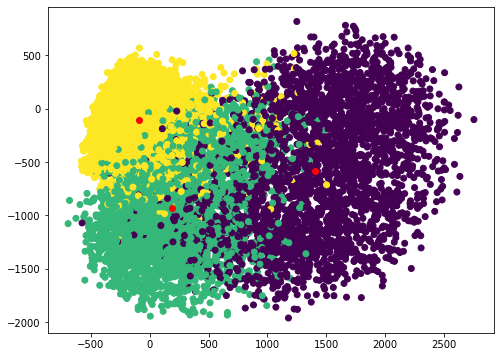

In [37]:
# Write a function that takes as input a matrix X and
# an integer k and returns Z = Uk^T X, the PCA of X
import matplotlib.pyplot as plt
def PCA(X,k):
    
    mean = np.mean(X, axis=1)
    X_centered = X - mean[:, None]
    print(f'Shape of Xtrain_centered: {X_centered.shape}')
    U, s, VT = np.linalg.svd(X_centered, full_matrices=False)
    print(f'Shape of U : {U.shape}')
    
    U_k = U[:,:k]
    Z_PCA = U_k.T@X
    print(f'Shape of Z_PCA: {Z_PCA.shape}')
    # Visualize the clusters
    plt.figure(figsize=(8, 6))
    plt.scatter(Z_PCA[0, :], Z_PCA[1, :], c=Ytrain)
    for i in range(len(digits)):
        print(f"Position of centroids for each cluster (PCA): { np.mean(U_k.T @X[:, Ytrain == digits[i]], axis=1)}")
        C=np.mean(U_k.T @X[:, Ytrain == digits[i]], axis=1)
        plt.scatter(C[0],C[1],c='r')
    plt.show()
          
#     for i in range(len(digits)):
#         print(f"Position of centroids for each cluster (PCA): { np.mean(U_k.T @X[:, Ytrain == digits[i]], axis=1)}")
    return U_k
    
U_k=PCA(Xtrain,2)
Z_PCA = U_k.T@Xtrain

Shape of Z_LDA: (2, 9000)
Position of centroids for each cluster (LDA): [-0.03346238 -0.0002991 ] 
Position of centroids for each cluster (LDA): [ 0.00587668 -0.03444196] 
Position of centroids for each cluster (LDA): [0.03056209 0.03004099] 


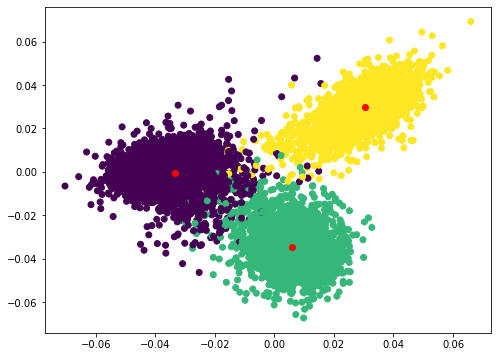

In [24]:
def LDA(X,k):
    
    # Within-clusters centroid
    C1 = np.mean(X1, axis=1)
    C2 = np.mean(X2, axis=1)
    C3 = np.mean(X3, axis=1)

    # Global centroid
    C = np.mean(X, axis=1)

    # Center each cluster dataset
    X1c = X1 - C1.reshape((d, 1))
    X2c = X2 - C2.reshape((d, 1))
    X3c = X3 - C3.reshape((d, 1))

    # Compute the within-cluster matrix by concatenation
    Xw = np.concatenate((X1c, X2c, X3c), axis=1)

    # Compute the within-cluster scatter matrix
    Sw = Xw @ Xw.T

    # Compute the Xbars
    Xbar1 = np.repeat(C1.reshape(d, 1), X1.shape[1], axis=1)
    Xbar2 = np.repeat(C2.reshape(d, 1), X2.shape[1], axis=1)
    Xbar3 = np.repeat(C3.reshape(d, 1), X3.shape[1], axis=1)

    # Compute the between-cluster dataset
    Xbar = np.concatenate((Xbar1, Xbar2, Xbar3), axis=1)

    # Compute the between-cluster centered dataset
    Xbarc = Xbar - C.reshape((d, 1))

    # Compute the between-cluster scatter matrix
    Sb = Xbarc @ Xbarc.T
    
    # We want to compute the Cholesky decomposition of Sw
    try:
        L = np.linalg.cholesky(Sw)
    except:
        epsilon = 1e-6
        Sw = Sw + epsilon * np.eye(Sw.shape[0])

        L = np.linalg.cholesky(Sw)
        
    # Compute the first k eigenvector decomposition of L^-1 Sb L
    _, W = scipy.sparse.linalg.eigs(np.linalg.inv(L) @ Sb @ L, k=2)
    W = np.real(W)

    # Compute Q
    Q = np.linalg.inv(L).T @ W
    
    # Compute the projection
    Z_LDA = Q.T @ X
    print(f'Shape of Z_LDA: {Z_LDA.shape}')
    
    #Visualization
    plt.figure(figsize=(8, 6))
    plt.scatter(Z_LDA[0, :], Z_LDA[1, :], c=Ytrain)
    for i in range(len(digits)):
        print(f"Position of centroids for each cluster (LDA): {np.mean(Q.T @ X[:, Ytrain == digits[i]], axis=1)} ")
        C=np.mean(Q.T @ X[:, Ytrain == digits[i]], axis=1)
        plt.scatter(C[0],C[1],c='r')
    plt.show()

#     for i in range(len(digits)):
#         print(f"Position of centroids for each cluster (LDA): {np.mean(Q.T @ X[:, Ytrain == digits[i]], axis=1)} ")
    return Q

Q = LDA(Xtrain,2)
Z_LDA = Q.T @ Xtrain

In [20]:
#For both the algorithms, compute for each cluster the average distance from the centroid.

for i in range(len(digits)):
    idx = np.where(Ytrain == digits[i])
    
    dist_pca = np.linalg.norm(Xtrain[:, idx] - U_k.T @ np.mean(Xtrain[:, idx], axis=1), axis=0)
    avg_dist_pca = np.mean(dist_pca)
    print(f'Average distance from the centroid for cluster {digits[i]} (PCA): {avg_dist_pca}')
    
    dist_lda = np.linalg.norm(Xtrain[:, idx] - Q.T @ np.mean(Xtrain[:, idx], axis=1), axis=0)
    avg_dist_lda = np.mean(dist_lda)
    print(f"Average distance from the centroid for cluster {digits[i]} (LDA): {avg_dist_lda}")
    print()

Average distance from the centroid for cluster 0 (PCA): 16946.863569307116
Average distance from the centroid for cluster 0 (LDA): 2746.8169686884926

Average distance from the centroid for cluster 6 (PCA): 14911.162817946923
Average distance from the centroid for cluster 6 (LDA): 2439.130032545468

Average distance from the centroid for cluster 9 (PCA): 13026.101173601486
Average distance from the centroid for cluster 9 (LDA): 2278.5726543572277



In [ ]:
#For both the algorithms, computing for each cluster the average distance from the centroid on the test set.

for i in range(len(digits)):
    idx = np.where(Ytest == digits[i])
    
    dist_pca = np.linalg.norm(Xtest[:, idx] - U_k.T @ np.mean(Xtest[:, idx], axis=1), axis=0)
    avg_dist_pca = np.mean(dist_pca)
    print(f"Average distance from the centroid for cluster {digits[i]} (PCA): {avg_dist_pca}")
    
    dist_lda = np.linalg.norm(Xtest[:, idx] - Q.T @ np.mean(Xtest[:, idx], axis=1), axis=0)
    avg_dist_lda = np.mean(dist_lda)
    print(f"Average distance from the centroid for cluster {digits[i]} (LDA): {avg_dist_lda}")
    print()

In [ ]:
#Define a classification algorithm in this way: given a new observation x, compute the distance between 
#x and each cluster centroid. Assign x to the class corresponding the the closer centroid. Compute the
#accuracy of this algorithm on the test set and compute its accuracy for both PCA and LDA

# def classify(x, centroids):
#     dist = np.linalg.norm(centroids - x[:, np.newaxis], axis=0)
#     return np.argmin(dist)

# centroids_pca = np.mean(U_k.T @ Xtest, axis=1)
# centroids_lda = np.mean(Q.T @ Xtest, axis=1)
# acc_pca = 0
# for i in range(Xtest.shape[1]):
#     if classify(U_k.T @ Xtest[:, i], centroids_pca) == Ytest[i]:
#         acc_pca += 1
# acc_pca /= Xtest.shape[1]
# print(f"Accuracy of the classification algorithm for PCA: {acc_pca}")
# acc_lda = 0
# for i in range(Xtest.shape[1]):
#     if classify(Q.T @ Xtest[:, i], centroids_lda) == Ytest[i]:
#         acc_lda += 1
# acc_lda /= Xtest.shape[1]
# print(f"Accuracy of the classification algorithm for LDA: {acc_lda}")

In [38]:
#Define a classification algorithm in this way: given a new observation x, compute the distance between 
#x and each cluster centroid. Assign x to the class corresponding the the closer centroid. Compute the
#accuracy of this algorithm on the test set and compute its accuracy for both PCA and LDA

def c_k(x, y, d):
#     print(x.shape)
#     print(y.shape)
    I = (y == d)
#     print("*")
#     print(I)
    tmp_X = x[:, I]
    return np.mean(tmp_X, axis = 1)

def classify(Z, y, P, x, chosen_numbers = digits):
    z = P @ x
    cs = [c_k(Z, y, c) for c in digits]
    ds = [np.linalg.norm((z - c)) for c in cs]

    idx = np.argmin(ds)
    return chosen_numbers[idx]
hitting = {"pca": 0, "lda": 0}
for index, elem in enumerate(Xtest.T):
    true_digit = Ytest[index]
    if classify(Z_PCA, Ytrain, U_k.T, elem) == true_digit:
        hitting["pca"]+=1
#     if classify(Z_pca_3, Ytrain, P_pca_3, elem) == true_digit:
#         hitting["pca_3"]+=1
    if classify(Z_LDA, Ytrain, Q.T, elem) == true_digit:
        hitting["lda"]+=1
#     if classify(Z_lda_3, Ytrain, P_lda_3, elem) == true_digit:
#         hitting["lda_3"]+=1
accuracy = {"pca": 0, "lda": 0}
for idx in {"pca", "lda"}:
    accuracy[idx] = hitting[idx]/len(Xtest.T)*100
print(f"Hitting values are = {hitting}")
print(f"Accuracy values are = {accuracy}")

Hitting values are = {'pca': 2928, 'lda': 3411}
Accuracy values are = {'pca': 84.69771478160256, 'lda': 98.66936650274805}
